# Setup

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00


In [2]:
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.1

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import NearMiss

import re
import nltk
from nltk.data import find
from nltk.corpus import stopwords
import string

from transformers import TFBertModel, BertTokenizer

import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.optimizers import Adam

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import os

MAX_SEQUENCE_LENGTH=100

# Data Imports






Data was filtered using BigQuery in Google Cloud, using the following SQL query:

    WITH top_10_dx_unplanned as
      (SELECT distinct d.icd9_code,
                      count(*) as dx_count
      FROM `physionet-data.mimiciii_clinical.diagnoses_icd` as d
      JOIN `physionet-data.mimiciii_clinical.admissions` as a
        ON d.subject_id = a.SUBJECT_ID and d.hadm_id = a.HADM_ID
      WHERE a.ADMISSION_TYPE in ('EMERGENCY', 'URGENT')
      GROUP BY icd9_code
      ORDER BY dx_count desc
      LIMIT 10),

      top_10_dx_planned as
      (SELECT distinct d.icd9_code,
                      count(*) as dx_count
      FROM `physionet-data.mimiciii_clinical.diagnoses_icd` as d
      JOIN `physionet-data.mimiciii_clinical.admissions` as a
        ON d.subject_id = a.SUBJECT_ID and d.hadm_id = a.HADM_ID
      WHERE a.ADMISSION_TYPE = 'ELECTIVE'
      GROUP BY icd9_code
      ORDER BY dx_count desc
      LIMIT 10)

    SELECT d.subject_id,
          d.hadm_id,
          a.ADMISSION_TYPE as admission_type,
          p.icd9_code as primary_px_ICD9,
          d.ICD9_CODE as primary_dx_ICD9,
          n.TEXT as note_text,
          CASE WHEN a.ADMISSION_TYPE in ('EMERGENCY', 'URGENT') THEN 1
          ELSE 0
          END AS UHA
    FROM `physionet-data.mimiciii_clinical.procedures_icd` as p
    JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` as d
      ON p.subject_id = d.SUBJECT_ID and p.hadm_id = d.HADM_ID
    JOIN `physionet-data.mimiciii_notes.noteevents` as n
      ON p.subject_id = n.SUBJECT_ID and p.hadm_id = n.HADM_ID
    JOIN `physionet-data.mimiciii_clinical.admissions` as a
      ON p.subject_id = a.SUBJECT_ID and p.hadm_id = a.HADM_ID
    WHERE p.seq_num = 1 and d.SEQ_NUM = 1 and (d.icd9_code in (SELECT icd9_code FROM top_10_dx_unplanned) OR d.icd9_code in (SELECT icd9_code FROM top_10_dx_planned))
    ORDER BY subject_id, hadm_id

In [9]:
df = pd.read_csv('/content/drive/MyDrive/W266 Final Project/Data/DX_Top_10.csv', low_memory=False)
df.head()

,subject_id,hadm_id,admission_type,primary_px_ICD9,primary_dx_ICD9,note_text,UHA
0,13,143045,EMERGENCY,3612,41401,[**2167-1-9**] 4:51 PM\n CHEST (PORTABLE AP) I...,1
1,13,143045,EMERGENCY,3612,41401,CCU ADMISSION NPN 1900-0700: LEFT MAIN\nHPI: I...,1
2,13,143045,EMERGENCY,3612,41401,Sinus rhythm/ Non-diagnostic inferior and late...,1
3,13,143045,EMERGENCY,3612,41401,Admission Date: [**2167-1-8**] Discharg...,1
4,13,143045,EMERGENCY,3612,41401,"ALTERED CARDIAC STATUS\nS: ""I HAVE TO USE THAT...",1


# Baseline Logistic Model - DX + PX only

In [10]:
df_baseline = df[['primary_dx_ICD9', 'primary_px_ICD9', 'UHA']]

In [11]:
df_baseline['UHA'].value_counts()

1    142572
0     39853
Name: UHA, dtype: int64

In [12]:
X_baseline = df_baseline.drop("UHA", axis=1).values
y_baseline = df_baseline["UHA"].values

In [13]:
# Undersample the positive class using NearMiss algorithm (looks for nearest neighbors between classes)
nm1 = NearMiss(version=1)
X_resampled_baseline, y_resampled_baseline = nm1.fit_resample(X_baseline, y_baseline)

In [14]:
# Train/Test Split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_resampled_baseline, y_resampled_baseline, test_size=0.2, random_state=42)

In [15]:
baseline_model = LogisticRegression(max_iter=500)

In [16]:
baseline_model.fit(X_train_baseline, y_train_baseline) # fit model

LogisticRegression(max_iter=500)

In [17]:
y_pred_baseline = baseline_model.predict(X_test_baseline)

In [18]:
baseline_rmse = mean_squared_error(y_test_baseline, y_pred_baseline, squared=False)
print(f"RMSE: {baseline_rmse:.3f}")
print(classification_report(y_test_baseline, y_pred_baseline))

RMSE: 0.652
              precision    recall  f1-score   support

           0       0.62      0.38      0.48      8014
           1       0.55      0.77      0.64      7928

    accuracy                           0.57     15942
   macro avg       0.59      0.58      0.56     15942
weighted avg       0.59      0.57      0.56     15942



# Apply Padding to PX and DX

In [19]:
dx_ICD9_code = df_baseline["primary_dx_ICD9"].values
px_ICD9_code = df_baseline["primary_px_ICD9"].values

dx_ICD9_code = [list(str(item)) for item in dx_ICD9_code]
px_ICD9_code = [list(str(item)) for item in px_ICD9_code]


target_length = 100
padded_dx_code = np.zeros((len(dx_ICD9_code), target_length), dtype=np.int32)
for i, seq in enumerate(dx_ICD9_code):
  seq_len = len(seq)
  if seq_len <= target_length:
      padded_dx_code[i, :seq_len] = seq
  else:
      padded_dx_code[i, :] = seq[:target_length]

padded_px_code = np.zeros((len(px_ICD9_code), target_length), dtype=np.int32)
for i, seq in enumerate(px_ICD9_code):
  seq_len = len(seq)
  if seq_len <= target_length:
      padded_px_code[i, :seq_len] = seq
  else:
      padded_px_code[i, :] = seq[:target_length]

print(padded_dx_code.shape)
print(padded_px_code.shape)



(182425, 100)
(182425, 100)


# Encode PX and DX Using Word2Vec

In [20]:
def tokenize_seq(padded_seq):
  return [seq[seq !=0].tolist() for seq in padded_seq]

#Create list of tokenized sequence removing padding of zeroes
tokenized_dx_code = tokenize_seq(padded_dx_code)
tokenized_px_code = tokenize_seq(padded_px_code)

#Train word2vec model on tokenized seq for dx
word2vec_model_dx_code = Word2Vec(sentences=tokenized_dx_code, vector_size=100, window=5, min_count=1, workers=4)

#Create func to encode a sequence using word2vec embeddings for dx
def encode_dx_code(seq):
    return np.mean([word2vec_model_dx_code.wv[token] for token in seq], axis=0)

#Train word2vec model on tokenized seq for px
word2vec_model_px_code = Word2Vec(sentences=tokenized_px_code, vector_size=100, window=5, min_count=1, workers=4)

#Create func to encode a sequence using word2vec embeddings for px
def encode_px_code(seq):
    return np.mean([word2vec_model_px_code.wv[token] for token in seq], axis=0)

#Encode sequence in padded dx and px using word2vec embeddings
encoded_dx_code = np.array([encode_dx_code(seq) for seq in tokenized_dx_code])
encoded_px_code = np.array([encode_px_code(seq) for seq in tokenized_px_code])

print(encoded_dx_code.shape)
print(encoded_px_code.shape)

(182425, 100)
(182425, 100)


# Clean Text
Remove stop words, alpha numeric characters and punctuation.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
#Create func to remove alpanumeric characters and punctuation
def clean_text(text):
    #Remove alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)

    #Remove punctuation marks
    text = ''.join(ch for ch in text if ch not in string.punctuation)

    return text

#Create func to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))

    #Split text into words
    words = text.split()
    #Remove stop words
    words = [word for word in words if word.lower() not in stop_words]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [23]:
df['cleaned_note_text'] = df['note_text'].apply(lambda x: remove_stop_words(clean_text(x)))
df.head()

,subject_id,hadm_id,admission_type,primary_px_ICD9,primary_dx_ICD9,note_text,UHA,cleaned_note_text
0,13,143045,EMERGENCY,3612,41401,[**2167-1-9**] 4:51 PM\n CHEST (PORTABLE AP) I...,1,216719 451 PM CHEST PORTABLE AP FEMUR AP LAT S...
1,13,143045,EMERGENCY,3612,41401,CCU ADMISSION NPN 1900-0700: LEFT MAIN\nHPI: I...,1,CCU ADMISSION NPN 19000700 LEFT MAIN HPI BREIF...
2,13,143045,EMERGENCY,3612,41401,Sinus rhythm/ Non-diagnostic inferior and late...,1,Sinus rhythm Nondiagnostic inferior lateral ST...
3,13,143045,EMERGENCY,3612,41401,Admission Date: [**2167-1-8**] Discharg...,1,Admission Date 216718 Discharge Date 2167115 D...
4,13,143045,EMERGENCY,3612,41401,"ALTERED CARDIAC STATUS\nS: ""I HAVE TO USE THAT...",1,ALTERED CARDIAC STATUS USE THING EVERY HOUR CA...


# Create Train and Test Sets

In [24]:
df_nlp = df[['cleaned_note_text', 'UHA']]
df_nlp.head()

,cleaned_note_text,UHA
0,216719 451 PM CHEST PORTABLE AP FEMUR AP LAT S...,1
1,CCU ADMISSION NPN 19000700 LEFT MAIN HPI BREIF...,1
2,Sinus rhythm Nondiagnostic inferior lateral ST...,1
3,Admission Date 216718 Discharge Date 2167115 D...,1
4,ALTERED CARDIAC STATUS USE THING EVERY HOUR CA...,1


In [25]:
texts = df_nlp['cleaned_note_text'].values
labels = df_nlp['UHA'].values

In [26]:
# Split training and testing sets for three features and label
X_train_nlp, X_test_nlp, X_train_encoded_px, X_test_encoded_px, X_train_encoded_dx, X_test_encoded_dx, y_train_nlp, y_test_nlp = train_test_split(
    texts, encoded_px_code, encoded_dx_code, labels, test_size=0.2, random_state=42
)

# Tokenize CNN Data

In [27]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [28]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [29]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(X_train_nlp)
test_tokens = tokenizer.tokenize(X_test_nlp)

In [30]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [31]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(y_train_nlp)
test_labels = np.array(y_test_nlp)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Examples processed:  55000
Examples processed:  60000
Examples processed:  65000
Examples processed:  70000
Examples processed:  75000
Examples processed:  80000
Examples processed:  85000
Examples processed:  90000
Examples processed:  95000
Examples processed:  100000
Examples processed:  105000
Examples processed:  110000
Examples processed:  115000
Examples processed:  120000
Examples processed:  125000
Examples processed:  130000
Examples processed:  135000
Examples processed:  140000
Examples processed:  145000
Total examples:  145939
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Exam

## Create CNN Model (Text Only)

In [32]:
from tensorflow.keras import backend as K

def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((p * r) / (p + r + K.epsilon()))

    return f1_score

In [33]:
def create_cnn_model(MAX_SEQUENCE_LENGTH=100,
                     hidden_size = 200,
                     dropout=0.3,
                     kernel_size=5,
                     filters=32,
                     learning_rate=0.00005):

    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_layer)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    cnn_model = tf.keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', custom_f1_score])

    return cnn_model

In [34]:
cnn_model = create_cnn_model()

In [35]:
cnn_history = cnn_model.fit(train_input,
                            y_train_nlp,
                            validation_data=(test_input, y_test_nlp),
                            batch_size=5,
                            epochs=1
                            )

29188/29188 [==============================] - 164s 5ms/step - loss: 0.4041 - accuracy: 0.8193 - custom_f1_score: 0.8791 - val_loss: 0.3761 - val_accuracy: 0.8298 - val_custom_f1_score: 0.8822


# Create CNN + Attention Model (Text Only)

In [54]:
def create_cnn_attention_model(MAX_SEQUENCE_LENGTH=100,
                     hidden_size = 200,
                     dropout=0.3,
                     kernel_size=5,
                     filters=32,
                     learning_rate=0.00005):

    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    one_vector = tf.Variable(tf.ones((1, 1, 1)))
    batch_of_ones = tf.tile(one_vector, (tf.shape(cnn_input_layer)[0], 1, 1))
    query_layer = tf.keras.layers.Dense(conv_layer.shape[1])
    query_vector = query_layer(batch_of_ones)

    attention_output = tf.keras.layers.Attention()([query_vector, conv_layer], return_attention_scores=True)

    attention_scores = attention_output[1]
    context_vectors = tf.keras.layers.Reshape((attention_output[0].shape[-1],))(attention_output[0])

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(context_vectors)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    cnn_attention_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    cnn_attention_model = tf.keras.Model(inputs=cnn_input_layer, outputs=[cnn_attention_prediction, attention_scores])
    cnn_attention_model.compile(optimizer='adam',
                      loss=['binary_crossentropy', None],
                      metrics=['accuracy', custom_f1_score, None])

    return cnn_attention_model

In [55]:
cnn_attention_model = create_cnn_attention_model()

cnn_attention_history = cnn_attention_model.fit(train_input,
                            y_train_nlp,
                            validation_data=(test_input, y_test_nlp),
                            batch_size=5,
                            epochs=1
                            )

29188/29188 [==============================] - 166s 6ms/step - loss: 0.5151 - dense_4_loss: 0.5151 - dense_4_accuracy: 0.7818 - dense_4_custom_f1_score: 0.8641 - attention_accuracy: 0.2022 - attention_custom_f1_score: 0.0193 - val_loss: 0.5128 - val_dense_4_loss: 0.5128 - val_dense_4_accuracy: 0.7805 - val_dense_4_custom_f1_score: 0.8629 - val_attention_accuracy: 0.2053 - val_attention_custom_f1_score: 0.0061


## Create CNN Model (Text + PX + DX)

In [ ]:
def create_cnn_model_2(MAX_SEQUENCE_LENGTH=100,
                     hidden_size = 200,
                     dropout=0.3,
                     kernel_size=3,
                     filters=32,
                     learning_rate=0.00005):

    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=3, padding='valid')(cnn_embeddings)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    input_px = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_px')
    input_dx = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_dx')

    #Concatenate embedding with dx and px
    concatenated = tf.keras.layers.concatenate([conv_layer, input_px, input_dx], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_layer)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    cnn_model_2 = tf.keras.Model(inputs=[cnn_input_layer, input_px, input_dx], outputs=cnn_prediction)
    cnn_model_2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return cnn_model_2

In [ ]:
cnn_model_2 = create_cnn_model_2()

In [ ]:
cnn_model_2_history = cnn_model_2.fit([train_input, X_train_encoded_px, X_train_encoded_dx],
                            train_labels,
                            validation_data=([test_input, X_test_encoded_px, X_test_encoded_dx], test_labels),
                            batch_size=5,
                            epochs=1
)

24852/24852 [==============================] - 275s 11ms/step - loss: 0.3768 - accuracy: 0.8398 - val_loss: 0.3605 - val_accuracy: 0.8464


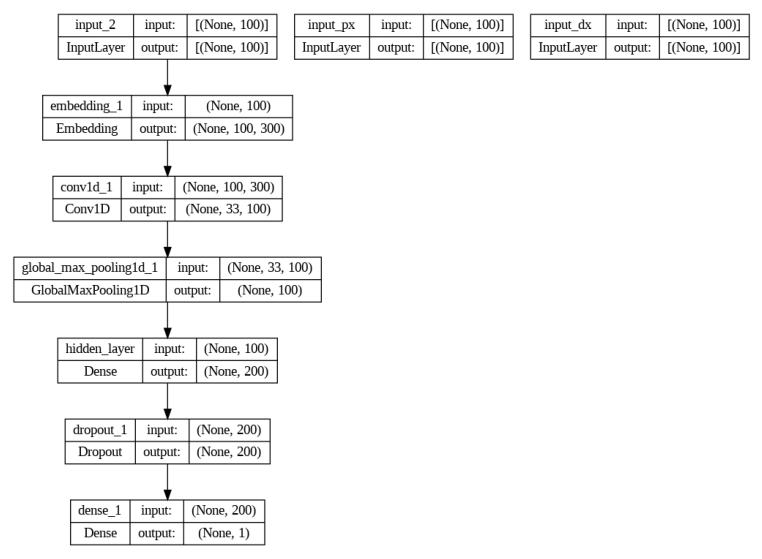

In [ ]:
model = create_cnn_model_2()

# Plot the model architecture and save it as a file
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
plt.figure(figsize=(10, 7))
img = plt.imread('cnn_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
cnn_model_2_history_2 = cnn_model_2.fit([train_input, X_train_encoded_px, X_train_encoded_dx],
                            train_labels,
                            validation_data=([test_input, X_test_encoded_px, X_test_encoded_dx], test_labels),
                            batch_size=64,
                            epochs=5,
                            callbacks=[model_checkpoint_callback]
)

Epoch 1/5
1942/1942 [==============================] - 988s 506ms/step - loss: 0.3662 - accuracy: 0.8435 - val_loss: 0.3398 - val_accuracy: 0.8572
Epoch 2/5
1942/1942 [==============================] - 969s 499ms/step - loss: 0.3119 - accuracy: 0.8662 - val_loss: 0.3469 - val_accuracy: 0.8520
Epoch 3/5
1942/1942 [==============================] - 912s 470ms/step - loss: 0.2613 - accuracy: 0.8878 - val_loss: 0.3577 - val_accuracy: 0.8590
Epoch 4/5
1942/1942 [==============================] - 907s 467ms/step - loss: 0.2083 - accuracy: 0.9116 - val_loss: 0.4420 - val_accuracy: 0.8554
Epoch 5/5
1942/1942 [==============================] - 927s 478ms/step - loss: 0.1711 - accuracy: 0.9281 - val_loss: 0.5142 - val_accuracy: 0.8407


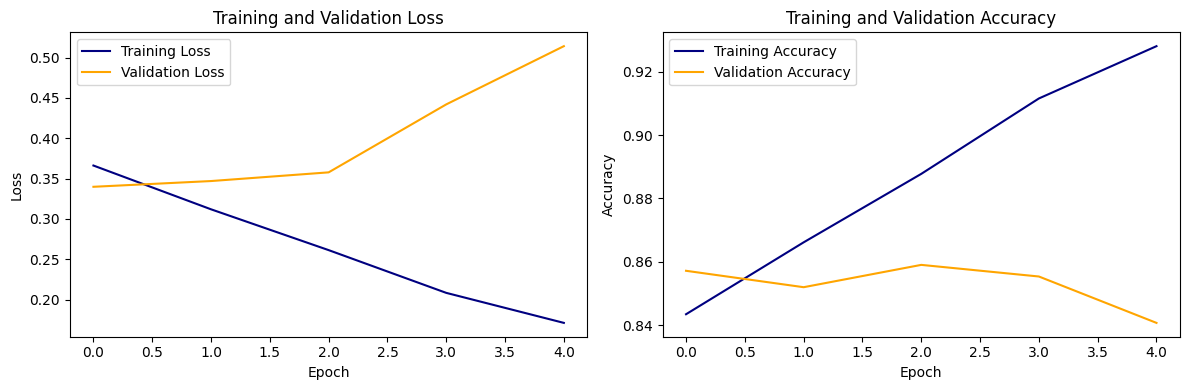

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(cnn_model_2_history_2.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_model_2_history_2.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_model_2_history_2.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_model_2_history_2.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
cnn_model_2_history_3 = cnn_model_2.fit([train_input, X_train_encoded_px, X_train_encoded_dx],
                            train_labels,
                            validation_data=([test_input, X_test_encoded_px, X_test_encoded_dx], test_labels),
                            batch_size=32,
                            epochs=5,
                            callbacks=[model_checkpoint_callback]
)

Epoch 1/5
3884/3884 [==============================] - 133s 31ms/step - loss: 0.3670 - accuracy: 0.8428 - val_loss: 0.3418 - val_accuracy: 0.8556
Epoch 2/5
3884/3884 [==============================] - 45s 11ms/step - loss: 0.3163 - accuracy: 0.8648 - val_loss: 0.3370 - val_accuracy: 0.8605
Epoch 3/5
3884/3884 [==============================] - 48s 12ms/step - loss: 0.2686 - accuracy: 0.8851 - val_loss: 0.3475 - val_accuracy: 0.8595
Epoch 4/5
3884/3884 [==============================] - 42s 11ms/step - loss: 0.2197 - accuracy: 0.9071 - val_loss: 0.4207 - val_accuracy: 0.8564
Epoch 5/5
3884/3884 [==============================] - 46s 12ms/step - loss: 0.1835 - accuracy: 0.9227 - val_loss: 0.4866 - val_accuracy: 0.8543


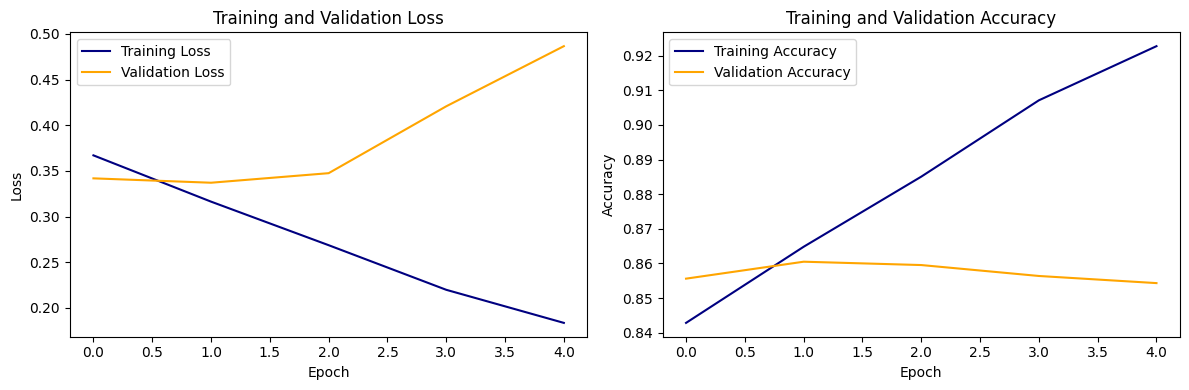

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(cnn_model_2_history_3.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_model_2_history_3.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_model_2_history_3.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_model_2_history_3.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def create_cnn_model_3(MAX_SEQUENCE_LENGTH=100,
                     hidden_size = 200,
                     dropout=0.3,
                     kernel_size=3,
                     filters=16,
                     learning_rate=0.00005):

    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layer = tf.keras.layers.Conv1D(filters=16, kernel_size=kernel_size, strides=3, padding='valid')(cnn_embeddings)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    input_px = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_px')
    input_dx = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_dx')

    #Concatenate embedding with dx and px
    concatenated = tf.keras.layers.concatenate([conv_layer, input_px, input_dx], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_layer)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    cnn_model_3 = tf.keras.Model(inputs=[cnn_input_layer, input_px, input_dx], outputs=cnn_prediction)
    cnn_model_3.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return cnn_model_3

In [ ]:
cnn_model_3 = create_cnn_model_3()

In [ ]:
cnn_model_3_history = cnn_model_3.fit([train_input, X_train_encoded_px, X_train_encoded_dx],
                            train_labels,
                            validation_data=([test_input, X_test_encoded_px, X_test_encoded_dx], test_labels),
                            batch_size=32,
                            epochs=5,
                            callbacks=[model_checkpoint_callback]
)

Epoch 1/5
3884/3884 [==============================] - 113s 25ms/step - loss: 0.3765 - accuracy: 0.8398 - val_loss: 0.3579 - val_accuracy: 0.8482
Epoch 2/5
3884/3884 [==============================] - 48s 12ms/step - loss: 0.3342 - accuracy: 0.8546 - val_loss: 0.3493 - val_accuracy: 0.8525
Epoch 3/5
3884/3884 [==============================] - 43s 11ms/step - loss: 0.3040 - accuracy: 0.8693 - val_loss: 0.3537 - val_accuracy: 0.8559
Epoch 4/5
3884/3884 [==============================] - 40s 10ms/step - loss: 0.2752 - accuracy: 0.8811 - val_loss: 0.3781 - val_accuracy: 0.8528
Epoch 5/5
3884/3884 [==============================] - 44s 11ms/step - loss: 0.2494 - accuracy: 0.8925 - val_loss: 0.3974 - val_accuracy: 0.8527


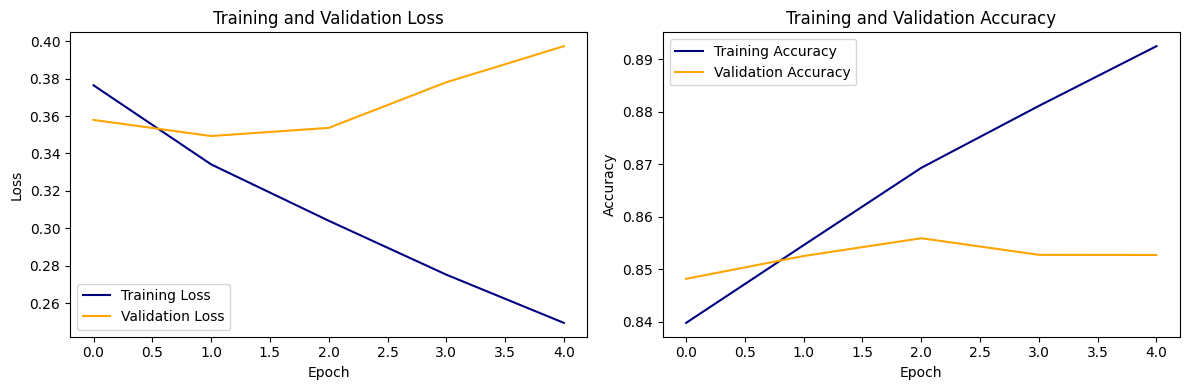

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(cnn_model_3_history.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_model_3_history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_model_3_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_model_3_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from keras import regularizers
def create_cnn_model_4(MAX_SEQUENCE_LENGTH=100,
                     hidden_size = 200,
                     dropout=0.3,
                     kernel_size=3,
                     filters=16,
                     learning_rate=0.00005):

    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layer = tf.keras.layers.Conv1D(filters=16, kernel_size=kernel_size, strides=3, padding='valid')(cnn_embeddings)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    input_px = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_px')
    input_dx = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_dx')

    #Concatenate embedding with dx and px
    concatenated = tf.keras.layers.concatenate([conv_layer, input_px, input_dx], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='hidden_layer')(conv_layer)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    cnn_model_4 = tf.keras.Model(inputs=[cnn_input_layer, input_px, input_dx], outputs=cnn_prediction)
    cnn_model_4.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return cnn_model_4

In [ ]:
cnn_model_4 = create_cnn_model_4()

In [ ]:
cnn_model_4_history = cnn_model_4.fit([train_input, X_train_encoded_px, X_train_encoded_dx],
                            train_labels,
                            validation_data=([test_input, X_test_encoded_px, X_test_encoded_dx], test_labels),
                            batch_size=32,
                            epochs=5,
                            callbacks=[model_checkpoint_callback]
)

Epoch 1/5
3884/3884 [==============================] - 84s 21ms/step - loss: 0.3861 - accuracy: 0.8378 - val_loss: 0.3596 - val_accuracy: 0.8432
Epoch 2/5
3884/3884 [==============================] - 45s 12ms/step - loss: 0.3416 - accuracy: 0.8498 - val_loss: 0.3580 - val_accuracy: 0.8440
Epoch 3/5
3884/3884 [==============================] - 41s 11ms/step - loss: 0.3105 - accuracy: 0.8651 - val_loss: 0.3609 - val_accuracy: 0.8486
Epoch 4/5
3884/3884 [==============================] - 40s 10ms/step - loss: 0.2807 - accuracy: 0.8811 - val_loss: 0.3735 - val_accuracy: 0.8515
Epoch 5/5
3884/3884 [==============================] - 39s 10ms/step - loss: 0.2531 - accuracy: 0.8954 - val_loss: 0.3965 - val_accuracy: 0.8462


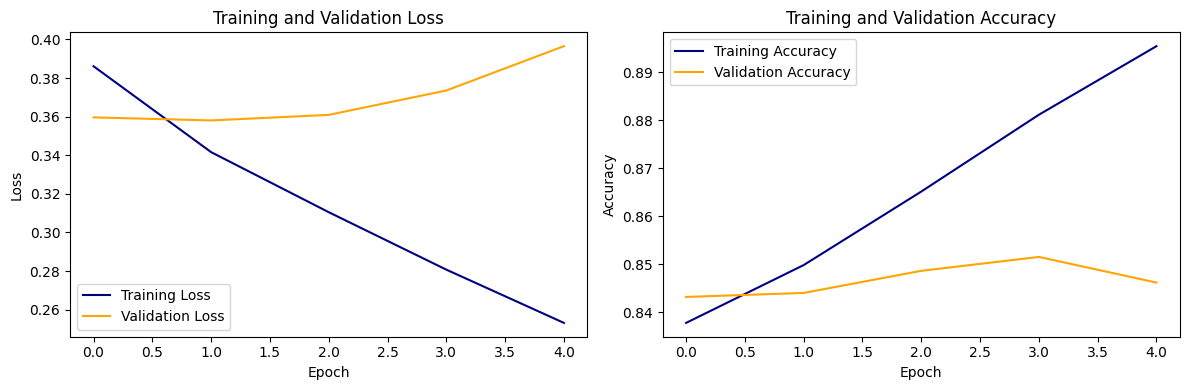

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(cnn_model_4_history.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_model_4_history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_model_4_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_model_4_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(cnn_model_2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     13194600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 33, 100)      90100       ['embedding[0][0]']              
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 100)         0           ['conv1d[0][0]']                 
 xPooling1D)                                                                                  

# BERT Tokenization of Training and Test Data


In [39]:
#Load BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [40]:
MAX_SEQUENCE_LENGTH = 100

X_train_nlp = bert_tokenizer(list(X_train_nlp),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

X_test_nlp = bert_tokenizer(list(X_test_nlp),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

# Create BERT Model (Text Only)

In [41]:
def create_bert_model(MAX_SEQUENCE_LENGTH=100,
                                     hidden_size = 200,
                                     dropout=0.3,
                                     learning_rate=0.00005):

    #Load BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(bert_out)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    bert_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', custom_f1_score])

    return bert_model

In [42]:
bert_model = create_bert_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
bert_history = bert_model.fit([X_train_nlp.input_ids, X_train_nlp.token_type_ids, X_train_nlp.attention_mask],
                                y_train_nlp,
                                validation_data=([X_test_nlp.input_ids, X_test_nlp.token_type_ids, X_test_nlp.attention_mask], y_test_nlp),
                                batch_size=5,
                                epochs=1,
                            )

29188/29188 [==============================] - 1085s 36ms/step - loss: 0.5319 - accuracy: 0.7812 - custom_f1_score: 0.8636 - val_loss: 0.5278 - val_accuracy: 0.7805 - val_custom_f1_score: 0.8629


# Create Bert CNN Model

In [44]:
def create_bert_cnn_model(MAX_SEQUENCE_LENGTH=100,
                                     hidden_size = 200,
                                     dropout=0.3,
                                     kernel_size=5,
                                     filters=32,
                                     learning_rate=0.00005):

    #Load BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)[0]

    conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_out)
    conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_layer)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', custom_f1_score])

    return classification_model

In [45]:
bert_cnn_model = create_bert_cnn_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [46]:
# Add a model checkpoint callback to save
# the trained model weights after each epoch.

checkpoint_dir = '/content/drive/MyDrive/W266 Final Project/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'bert_cnn_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [48]:
bert_cnn_model = create_bert_cnn_model()

bert_cnn_model_history = bert_cnn_model.fit(
    [X_train_nlp.input_ids, X_train_nlp.token_type_ids, X_train_nlp.attention_mask],
    y_train_nlp,
    validation_data=([X_test_nlp.input_ids, X_test_nlp.token_type_ids, X_test_nlp.attention_mask], y_test_nlp),
    batch_size=5,
    epochs=1
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

29188/29188 [==============================] - 1084s 36ms/step - loss: 0.5306 - accuracy: 0.7818 - custom_f1_score: 0.8643 - val_loss: 0.5338 - val_accuracy: 0.7805 - val_custom_f1_score: 0.8629


In [49]:
# Split training and testing sets for three features and label
X_train_texts, X_test_texts, X_train_encoded_px, X_test_encoded_px, X_train_encoded_dx, X_test_encoded_dx, y_train, y_test = train_test_split(
    texts, encoded_px_code, encoded_dx_code, labels, test_size=0.2, random_state=42
)

In [50]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

MAX_SEQUENCE_LENGTH = 100

X_train_inputs = bert_tokenizer(
    list(X_train_texts),
    max_length=MAX_SEQUENCE_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test_inputs = bert_tokenizer(
    list(X_test_texts),
    max_length=MAX_SEQUENCE_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
